In [1]:
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
#Variables
path = "../HUPA-UC Diabetes Dataset/"
demographic_path = path + "T1DM_patient_sleep_demographics_with_race.csv"
all_patients_path = path + "ALL_PATIENTS.csv"
#modified_demographic_path = path+"DEMOGRAPHIC.csv"
#patients_demographic_path = path +"PATIENTS_WITH_DEMOGRAPHIC.csv"

In [5]:
patients_df = pd.read_csv(all_patients_path, parse_dates=["time"])
patients_df.columns

Index(['time', 'glucose', 'calories', 'heart_rate', 'steps', 'basal_rate',
       'bolus_volume_delivered', 'carb_input', 'patient_id'],
      dtype='object')

**What is the average glucose level for patients between midnight and 5 AM?**

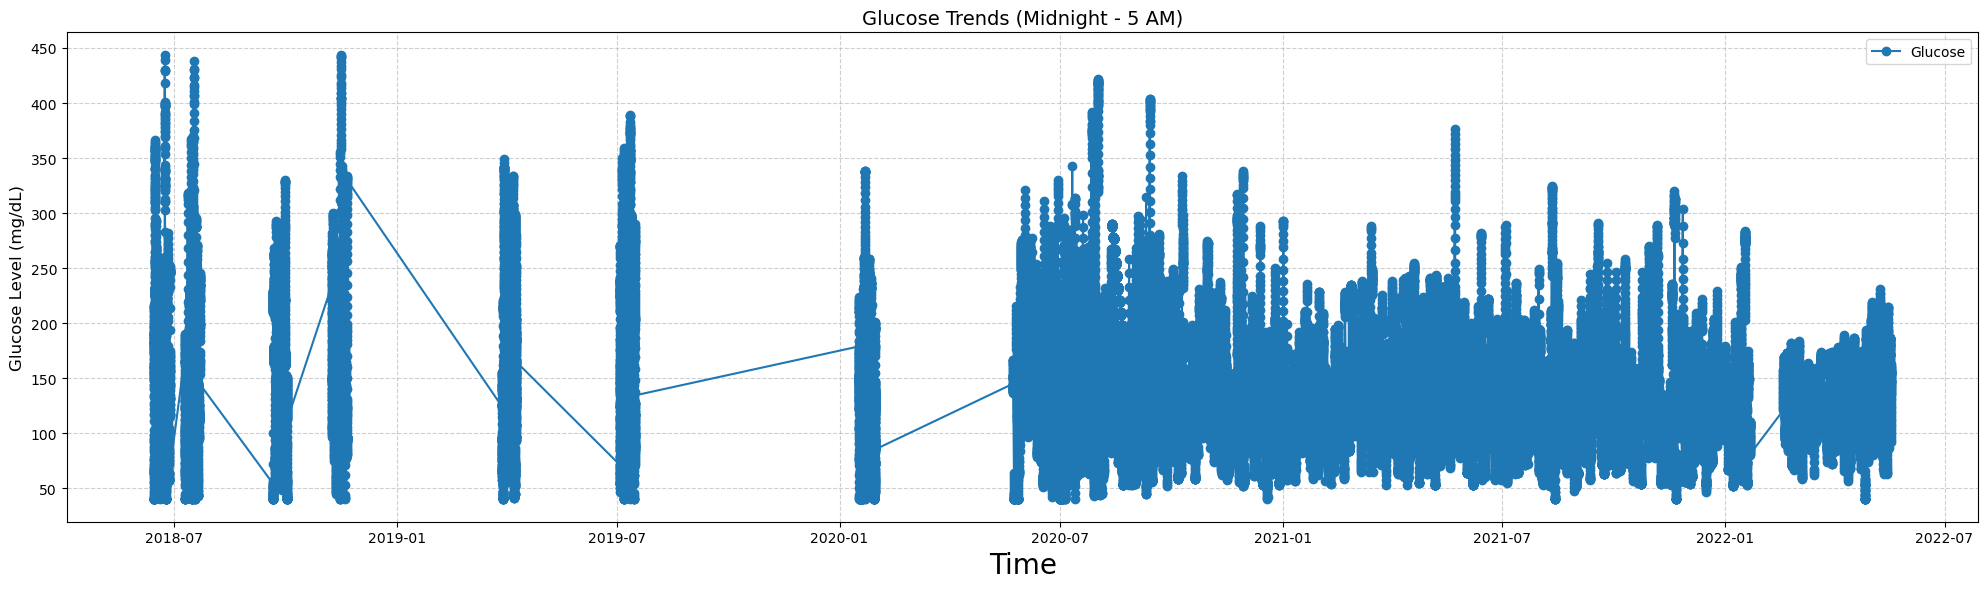

In [6]:
early_morning_df  = patients_df[(patients_df["time"].dt.hour >=0) & (patients_df["time"].dt.hour<5)].copy()
#early_morning_df.columns
#early_morning_df.head()
plt.figure(figsize=(20,6))
#for pid,group in early_morning_df.groupby("patient_id"):
#plt.plot(group["time"],group["glucose"], marker="o", linestyle="-", lable =pid)
plt.plot(early_morning_df["time"], early_morning_df["glucose"],label="Glucose",marker="o")
plt.title("Glucose Trends (Midnight - 5 AM)", fontsize=14)
plt.xlabel("Time", fontsize=20)
plt.ylabel("Glucose Level (mg/dL)", fontsize=12)
#plt.legend(Title="Patient_Id", bbox_to_anchor=(1.05,1),loc="upper_left")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

**Problem Statement : Compare overnight and daytime glucose levels across patients**

**Reasoning: Overnight (midnight–5 AM) glucose reflects basal insulin and fasting state. 
             and Daytime glucose is influenced by meals,activity,stress and bolus insulin.
             Comparing these two periods helps clinical assess whether insulin delivery(basal/bolus) or                          lifestyle modificiations like diet,exercise are effective**

In [14]:
# Steps:
# Create seperate dataframes for daytime and overnight dataset
# daytime_df: This dataframe contains avg glucose values taken during the daytime per patient per day.
# columns are:
#patient id: Patient Id
#date part from time column: This column used to join the overnight dataset to get avgerage of glucose values recorded during overnight on that day 
#is_daytime: This column identifies the at what day part the glucose reading is recorded
#daytime_avg_glucose: This column has a avg glucose value for all records in daytime period on a single day

#------------------------------------------------------------
#Adding extra date column while grouping for daytime
#Extracting all glucose values for the 
# daytime[from 6am till 12am] grouping by patient_id and date
#-------------------------------------------------------------
daytime_df = patients_df.assign(date=patients_df['time'].dt.date,is_daytime = patients_df['time'].dt.hour.between(6,23)).groupby(['patient_id','date','is_daytime'])['glucose'].mean().reset_index()
#------------------------------------------------------------
# Delete all rows having is_daytime == False ie records other 
# than daytime
#------------------------------------------------------------
daytime_df=daytime_df[daytime_df['is_daytime']==True]
#------------------------------------------------------------
# rename the glucose column with daytime_avg_glucose
# renaming to clean join with the overnight dataframe
#------------------------------------------------------------
daytime_df=daytime_df.rename(columns={'glucose':'daytime_avg_glucose'})
#------------------------------------------------------------
# Number of patients having records during daytime
#------------------------------------------------------------
print('Total number of patients having records during daytime: ' , daytime_df['patient_id'].nunique())
#------------------------------------------------------------
# Number of days having records during midnight
#------------------------------------------------------------
print('Total number of days on which glucose has recorded during daytime:', daytime_df['date'].nunique())

#------------------------------------------------------------
# Adding extra date column while grouping for daytime
# Extracting all glucose values for the daytime[from midnight till 6am] grouping by patient_id and date
#------------------------------------------------------------
overnight_df= patients_df.assign(date=patients_df['time'].dt.date,is_overnight = patients_df['time'].dt.hour.between(0,5)).groupby(['patient_id','date','is_overnight'])['glucose'].mean().reset_index()
#overnight_df
#------------------------------------------------------------
# Delete all rows having is_daytime == False ie records other than daytime
#------------------------------------------------------------
overnight_df=overnight_df[overnight_df['is_overnight']==True]
#------------------------------------------------------------
# rename the glucose column with daytime_avg_glucose
# renaming to clean join with the overnight dataframe
#------------------------------------------------------------
overnight_df = overnight_df.rename(columns={'glucose':'overnight_avg_glucose'})
#overnight_df.count()
#overnight_df
#------------------------------------------------------------
# Number of patients having records during overnight
#------------------------------------------------------------
print('Total number of patients having records during overnight: ' , overnight_df['patient_id'].nunique())
#------------------------------------------------------------
# Number of days having records during midnight
#------------------------------------------------------------
print('Total number of days on which glucose has recorded during overnight:', overnight_df['date'].nunique())

#------------------------------------------------------------
# Join two df on patient_id and date 
#------------------------------------------------------------
result_df = pd.merge(daytime_df, overnight_df, on = ['patient_id','date'], how="inner") #,suffixes=('_daytime_avg_','_overnight_avg_'))
#------------------------------------------------------------
# Rounding avg glucose values to 1
#------------------------------------------------------------
result_df = result_df.round({
    'daytime_avg_glucose':1,
    'overnight_avg_glucose':1
})
result_df['date'].nunique()
result_df['patient_id'].nunique()
#------------------------------------------------------------
# Number of patients having records during overnight and daytime on the same day
#------------------------------------------------------------
print('Total number of patients having records during overnight: ' , result_df['patient_id'].nunique())
#------------------------------------------------------------
# Number of days having records during midnight and daytime
#------------------------------------------------------------
print('Total number of days on which glucose has recorded during overnight:', result_df['date'].nunique())
#result_df.columns
#------------------------------------------------------------
# Number of records during overnight and daytime on the same day for a patient
#------------------------------------------------------------
print('Total number records during overnight and daytime on the same day for a patient:', len(result_df))

result_df[['patient_id','date','daytime_avg_glucose','overnight_avg_glucose']]


#------------------------------------------------------------
# Find the patients having less difference between 
# DayTime and Overnight average glucose values
#------------------------------------------------------------
result_df['diff'] = (result_df['daytime_avg_glucose'] - result_df['overnight_avg_glucose']).abs()
#------------------------------------------------------------
# Patients having the minimum difference in daytime and overnight avg glucose reading per day
#------------------------------------------------------------
min_diff_index = result_df['diff'].idxmin()
print('------------------------------------------------------------------------------------------')
print('Patients having the minimum difference in daytime and overnight avg glucose reading day:')
print(result_df.loc[min_diff_index,['patient_id','date','daytime_avg_glucose','overnight_avg_glucose']])
print('------------------------------------------------------------------------------------------')
#------------------------------------------------------------
# Patients having the maximum difference in daytime and overnight avg glucose reading per day
#------------------------------------------------------------
max_diff_index = result_df['diff'].idxmax()
print('Patients having the minimum difference in daytime and overnight avg glucose reading day:')
print(result_df.loc[max_diff_index,['patient_id','date','daytime_avg_glucose','overnight_avg_glucose']])
print('------------------------------------------------------------------------------------------')

#------------------------------------------------------------
# Patients getting spice in glucose values between 20 -50 units in daytime and overnight avg glucose reading per day
#------------------------------------------------------------
max_diff_index = result_df['diff'].idxmax()
print('Patients having the maximum difference in daytime and overnight avg glucose reading day:')
print(result_df.loc[max_diff_index,['patient_id','date','daytime_avg_glucose','overnight_avg_glucose']])

#------------------------------------------------------------
# Number of Patients having lower overnight reading than daytime reading 
#------------------------------------------------------------
rows = result_df.loc[result_df['daytime_avg_glucose']>= result_df['overnight_avg_glucose'],
['patient_id','date','overnight_avg_glucose', 'daytime_avg_glucose']]
print('------------------------------------------------------------------------------------------')
print('Number of Patients with overnight avgerage glucose lower than \nor equal to the daytime glucose reading per day: ',len(rows))
print('------------------------------------------------------------------------------------------')
# rows.reset_index(drop=True)
#result_df
#------------------------------------------------------------
# Number of Patients with overnight avgerage glucose greater than 
# the daytime avg glucose reading by 50 mg/dLper day
#------------------------------------------------------------
rows = result_df.loc[((result_df['daytime_avg_glucose']+50) < (result_df['overnight_avg_glucose'])),
['patient_id','date','overnight_avg_glucose', 'daytime_avg_glucose']]
print('Number of Patients with overnight avgerage glucose greater than \nthe daytime avg glucose reading by 50 mg/dLper day: ',len(rows))
print('------------------------------------------------------------------------------------------')

#------------------------------------------------------------
# Number of patients whose overnight average glucose is greater than daytime glucose 
# by more than 20 mg/dL but less than 50 mg/dL per day.
#------------------------------------------------------------

rows = result_df.loc[(
        (result_df['overnight_avg_glucose']>result_df['daytime_avg_glucose'])&
        (result_df['overnight_avg_glucose'] - result_df['daytime_avg_glucose'] >=20 )&
        (result_df['overnight_avg_glucose'] - result_df['daytime_avg_glucose'] <=50 )),
        ['patient_id','date','overnight_avg_glucose', 'daytime_avg_glucose']]
print('Number of patients whose overnight average glucose is greater than daytime glucose \nby more than 20 mg/dL but less than 50 mg/dL per day: ',len(rows))
print('------------------------------------------------------------------------------------------')
#------------------------------------------------------------
# Number of patients whose overnight average glucose is greater than daytime glucose 
# by less than 20 mg/dL per day
#------------------------------------------------------------

rows = result_df.loc[(
        (result_df['overnight_avg_glucose']>result_df['daytime_avg_glucose'])&
        (result_df['overnight_avg_glucose'] - result_df['daytime_avg_glucose'] <20 )),
        ['patient_id','date','overnight_avg_glucose', 'daytime_avg_glucose']]
print('Number of patients whose overnight average glucose is greater than daytime glucose \nby less than 20 mg/dL per day: ',len(rows))


Total number of patients having records during daytime:  25
Total number of days on which glucose has recorded during daytime: 800
Total number of patients having records during overnight:  25
Total number of days on which glucose has recorded during overnight: 792
Total number of patients having records during overnight:  25
Total number of days on which glucose has recorded during overnight: 792
Total number records during overnight and daytime on the same day for a patient: 1071
------------------------------------------------------------------------------------------
Patients having the minimum difference in daytime and overnight avg glucose reading day:
patient_id                HUPA0028P
date                     2022-04-22
daytime_avg_glucose           106.1
overnight_avg_glucose         106.1
Name: 1044, dtype: object
------------------------------------------------------------------------------------------
Patients having the minimum difference in daytime and overnight avg gluc

<pre><strong>
Acceptable Difference (Spice) Between Overnight & Daytime

For non-diabetic or well-controlled diabetic patients, overnight readings are usually  
lower than daytime post-meal readings.  

A difference of ~20–50 mg/dL is often reasonable; larger differences may indicate:
    High postprandial spikes
    Hypoglycemia overnight 
    Need for insulin/diet adjustment

**PLEASE NOTE:  
Exact values can vary based on age, medications, and clinical recommendations.</strong></pre>

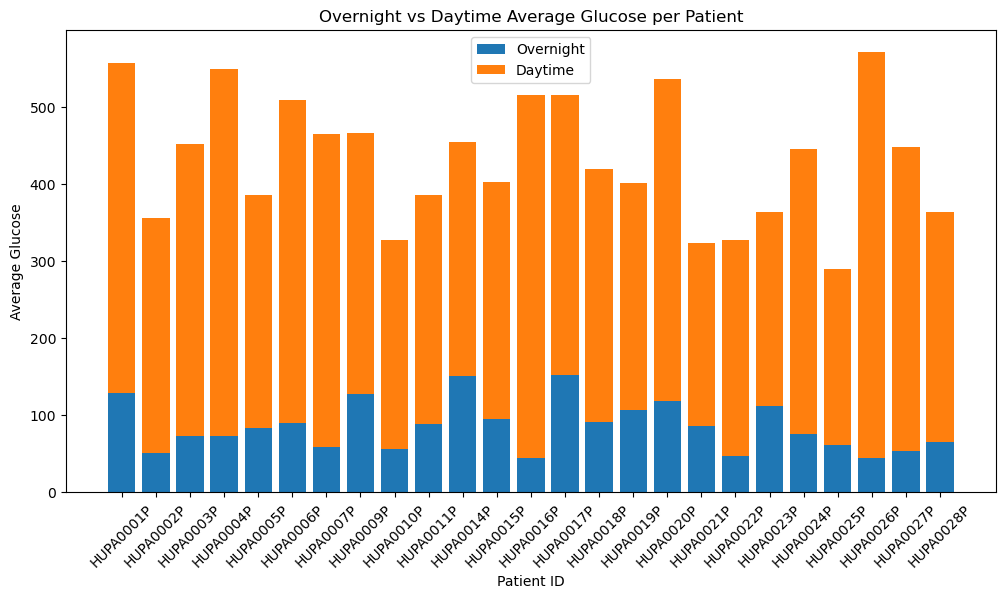

In [89]:

#Ploting grpah 
#It is taking a min and max values 
plt.figure(figsize=(12,6))
plt.bar(result_df['patient_id'], result_df['overnight_avg_glucose'], label='Overnight')
plt.bar(result_df['patient_id'], result_df['daytime_avg_glucose'], bottom=pivot_df['overnight_avg_glucose'], label='Daytime')
plt.xlabel("Patient ID")
plt.ylabel("Average Glucose")
plt.title("Overnight vs Daytime Average Glucose per Patient")
plt.xticks(rotation=45)
plt.legend()
plt.show()